In [9]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
import os
from tensorflow.keras.callbacks import TensorBoard
from tensorboard import notebook
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers


import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:

notebook.list() # View open TensorBoard instances
'''
! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "echo 'Done!'"
'''

No known TensorBoard instances running.


'\n! powershell "echo \'checking for existing tensorboard processes\'"\n! powershell "ps | Where-Object {$_.ProcessName -eq \'tensorboard\'}"\n\n! powershell "ps | Where-Object {$_.ProcessName -eq \'tensorboard\'}| %{kill $_}"\n\n! powershell "echo \'cleaning tensorboard temp dir\'"\n! powershell "rm $env:TEMP\\.tensorboard-info\\*"\n\n! powershell "ps | Where-Object {$_.ProcessName -eq \'tensorboard\'}"\n\n! powershell "echo \'Done!\'"\n'

In [6]:
# %reload_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [7]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

# Normalize data
fm_X_train = fm_X_train/255.0
fm_X_test = fm_X_test/255.0

# Add noise to images
noise_factor = 0.38

noise_train_dataset = list()
noise_test_dataset = list()

for img in fm_X_train:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_train_dataset.append(noisy_image)

for img in fm_X_test:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_test_dataset.append(noisy_image)
    
noise_train_dataset = np.array(noise_train_dataset)
noise_test_dataset = np.array(noise_test_dataset)

fm_X_train = np.reshape(fm_X_train, (len(fm_X_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_train_dataset = np.reshape(noise_train_dataset, (len(noise_train_dataset), 28, 28, 1))

fm_X_test = np.reshape(fm_X_test, (len(fm_X_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_test_dataset = np.reshape(noise_test_dataset, (len(noise_test_dataset), 28, 28, 1))

## Convolutional AutoEncoder

### Convolutional Encoder

In [18]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name = 'LatentSpace')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

encoder = Model(input_img, encoded, name='CNN_Encoder')
encoder.summary()

Model: "CNN_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
LatentSpace (MaxPooling2D)   (None, 4, 4, 8)           

### Convolutional Decoder

In [20]:
latent_space = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(latent_space)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation='sigmoid', padding='same')(x)

# create the decoder model
decoder = Model(latent_space, decoded, name='CNN_Decoder')
decoder.summary()

Model: "CNN_Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 4, 8)]         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 28, 28, 16)        

In [23]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name="CNN_autoencoder")
autoencoder.summary()

Model: "CNN_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
CNN_Encoder (Model)          (None, 4, 4, 8)           1904      
_________________________________________________________________
CNN_Decoder (Model)          (None, 28, 28, 1)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "CNN_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
CNN_Encoder (Model)          (None, 4, 4, 8)           1904      
_________________________________________________________________
CNN_Decoder (Model)          (None, 28, 28, 1)         2481      
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%m%d_%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

epochs = 2
batch_size = 128

HistoryAE = autoencoder.fit(noise_train_dataset,
                            fm_X_train,
                            epochs = epochs,
                            batch_size = batch_size,
#                             callbacks=[eStop, tensorboard_callback],
                            validation_data = (noise_test_dataset, fm_X_test)
                            )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3194 - val_loss: 0.3177
Epoch 2/2
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3140 - val_loss: 0.3148


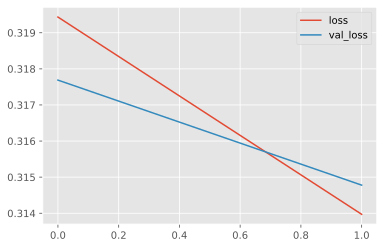

In [15]:
plt.plot(HistoryAE.history['loss'], label="loss")
plt.plot(HistoryAE.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [16]:
Evaluation = autoencoder.evaluate(noise_test_dataset,
                                  fm_X_test,
                                  batch_size=batch_size,
                                  verbose=2)

print('Test Loss: {:.3f}'.format(Evaluation))

10000/1 - 0s - loss: 0.3073
Test Loss: 0.315


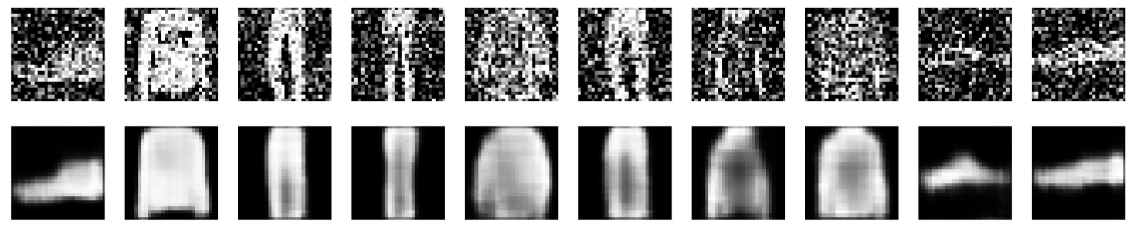

In [17]:
predicted = autoencoder.predict(noise_test_dataset[:10])

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_dataset[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
# %tensorboard --logdir logs --port=6061